# Natural Language Processing - Knowledge Graph example

###### Links: [Dataset (Wikipedia page: History of Rome)](https://en.wikipedia.org/wiki/History_of_Rome)  |  [Article (TowardsDataScience)]()

### 0 - Setup

###### Import pckgs

In [35]:
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd  #1.1.5

## for plotting
import matplotlib.pyplot as plt  #3.3.2
import seaborn as sns  #0.11.1

## for text
import wikipediaapi  #0.5.8
import nltk  #3.8.1
import re   
import contractions  #0.1.73

## for nlp
import spacy  #3.5.0
from spacy import displacy

## for graph
import networkx as nx  #3.0
import plotly.graph_objs as go  #5.1.0

## for timeline
import dateparser #1.1.7

###### Import data

In [13]:
wiki = wikipediaapi.Wikipedia('en')
page = wiki.page("History_of_Rome")
txt = page.text[:page.text.find("See also")]
txt[0:500] + " ..."

"The history of Rome includes the history of the city of Rome as well as the civilisation of ancient Rome. Roman history has been influential on the modern world, especially in the history of the Catholic Church, and Roman law has influenced many modern legal systems. Roman history can be divided into the following periods:\n\nPre-historical and early Rome, covering Rome's earliest inhabitants and the legend of its founding by Romulus\nThe period of Etruscan dominance and the regal period, in which, ..."

###### Text cleaning

In [ ]:
'''
Creates a list of stopwords.
:parameter
    :param lst_langs: list - ["english", "italian"]
    :param lst_add_words: list - list of new stopwords to add
    :param lst_keep_words: list - list words to keep (exclude from stopwords)
:return
    stop_words: list of stop words
'''      
def create_stopwords(lst_langs=["english"], lst_add_words=[], lst_keep_words=[]):
    lst_stopwords = set()
    for lang in lst_langs:
        lst_stopwords = lst_stopwords.union( set(nltk.corpus.stopwords.words(lang)) )
    lst_stopwords = lst_stopwords.union(lst_add_words)
    lst_stopwords = list(set(lst_stopwords) - set(lst_keep_words))
    return sorted(list(set(lst_stopwords)))

In [ ]:
lst_stopwords = create_stopwords(lst_add_words=[], lst_keep_words=[])
print(lst_stopwords)

In [ ]:
'''
Preprocess a string.
:parameter
    :param txt: string - name of column containing text
    :param dic_regex: dict - regex to replace
    :param punkt: bool - if True removes punctuations and characters
    :param lower: bool - if True convert lowercase
    :param slang: bool - if True fix slang into normal words
    :param lst_stopwords: list - list of stopwords to remove
    :param stemm: bool - whether stemming is to be applied
    :param lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(txt, dic_regex=None, punkt=True, lower=True, slang=True, lst_stopwords=None, 
                          stemm=False, lemm=True):
    ## Regex (in case, before cleaning)
    if dic_regex is not None: 
        for k,v in dic_regex.items():
            txt = re.sub(k, v, txt)

    ## Clean 
    ### separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    ### remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt) if punkt is True else txt
    ### strip
    txt = " ".join([word.strip() for word in txt.split()])
    ### lowercase
    txt = txt.lower() if lower is True else txt
    ### slang
    txt = contractions.fix(txt) if slang is True else txt
            
    ## Tokenize (convert from string to list)
    lst_txt = txt.split()
                
    ## Stemming (remove -ing, -ly, ...)
    if stemm is True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_txt = [ps.stem(word) for word in lst_txt]
                
    ## Lemmatization (convert the word into root word)
    if lemm is True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_txt = [lem.lemmatize(word) for word in lst_txt]

    ## Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in lst_stopwords]
            
    ## Back to string
    txt = " ".join(lst_txt)
    return txt

In [ ]:
#txt = utils_preprocess_text(txt, dic_regex={"-":" "}, punkt=True, lower=False, slang=False, 
#                            lst_stopwords=lst_stopwords, stemm=False, lemm=False)

In [ ]:
'''
Compute n-grams frequency with nltk tokenizer.
:parameter
    :param txt: text
    :param ngrams: int or list - 1 for unigrams, 2 for bigrams, [1,2] for both
    :param top: num - plot the top frequent words
:return
    dtf_count: dtf with word frequency
'''
def word_freq(txt, ngrams=[1,2,3], top=10, figsize=(10,7)):
    lst_tokens = nltk.tokenize.word_tokenize(txt)
    ngrams = [ngrams] if type(ngrams) is int else ngrams
    
    ## calculate
    dtf_freq = pd.DataFrame()
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
        dtf_n["ngrams"] = n
        dtf_freq = dtf_freq.append(dtf_n)
    dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
    dtf_freq = dtf_freq.sort_values(["ngrams","freq"], ascending=[True,False])
    
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(top))
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()
    return dtf_freq

In [ ]:
# Find most common words in text
_ = word_freq(txt, ngrams=[1], top=30, figsize=(10,7))

### 1 - NLP

###### Model

In [14]:
#python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")
doc = nlp(txt)

###### Sentence Segmentation

In [15]:
lst_docs = [sent for sent in doc.sents]
print("sentences:", len(lst_docs))

i = 135
lst_docs[i]

sentences: 582


In January 49 BCE, Julius Caesar the conqueror of Gaul, marched his legions against Rome.

In [16]:
for v,m in enumerate(lst_docs):
    if len(m) < 20:
        print(m, "\n----", v)

The period was marked by vast expansion of Roman territory. 
---- 3
During the 5th century BCE, Rome gained regional dominance in Latium. 
---- 4
Medieval Rome is characterized by a break with Constantinople and the formation of the Papal States. 
---- 9
Rome was annexed by Napoleon and was part of the First French Empire from 1798 to 1814.
 
---- 15
Modern history, the period from the 19th century to the present.   
---- 16
Rome came under siege again after the Allied invasion of Italy and was bombed several times. 
---- 17
It was declared an open city on 14 August 1943. 
---- 18
Rome became the capital of the Italian Republic (established in 1946). 
---- 19
It is among the largest urban areas of the European Union and classified as a global city.

 
---- 21
Excavations made in 2014 have revealed a wall built long before the city's official founding year. 
---- 25
The brothers argued, Romulus killed Remus, and then named the city Rome after himself. 
---- 29
After the ensuing war with

###### Entity Extraction

In [17]:
print(lst_docs[i], "\n---")

for token in lst_docs[i]:
    print(token.text, "-->", "pos: "+token.pos_, "|", "dep: "+token.dep_, "")

In January 49 BCE, Julius Caesar the conqueror of Gaul, marched his legions against Rome. 
---
In --> pos: ADP | dep: prep 
January --> pos: PROPN | dep: nmod 
49 --> pos: NUM | dep: nummod 
BCE --> pos: PROPN | dep: pobj 
, --> pos: PUNCT | dep: punct 
Julius --> pos: PROPN | dep: compound 
Caesar --> pos: PROPN | dep: nsubj 
the --> pos: DET | dep: det 
conqueror --> pos: NOUN | dep: appos 
of --> pos: ADP | dep: prep 
Gaul --> pos: PROPN | dep: pobj 
, --> pos: PUNCT | dep: punct 
marched --> pos: VERB | dep: ROOT 
his --> pos: PRON | dep: poss 
legions --> pos: NOUN | dep: dobj 
against --> pos: ADP | dep: prep 
Rome --> pos: PROPN | dep: pobj 
. --> pos: PUNCT | dep: punct 


In [18]:
displacy.render(lst_docs[i], style="dep", options={"distance":100})

In [19]:
def extract_entities(doc):
    a, b, dep_prev_token, txt_prev_token, prefix, modifier = "", "", "", "", "", ""
    for token in doc:
        if token.dep_ != "punct":
            
            ## if compound --> current + last compound
            if token.dep_ == "compound":
                prefix = token.text
                if dep_prev_token == "compound":
                    prefix = txt_prev_token + " "+ token.text
            
            ## if modifier --> current + last compound
            if token.dep_.endswith("mod") == True:
                modifier = token.text
                if dep_prev_token == "compound":
                    modifier = txt_prev_token + " "+ token.text
            
            ## if subject --> entity A
            if token.dep_.find("subj") == True:
                a = modifier +" "+ prefix + " "+ token.text
                prefix, modifier, dep_prev_token, txt_prev_token = "", "", "", ""
            
            ## if object --> entity B
            if token.dep_.find("obj") == True:
                b = modifier +" "+ prefix +" "+ token.text
            
            dep_prev_token, txt_prev_token = token.dep_, token.text
    return (a.strip(), b.strip())

In [20]:
lst_entities = [extract_entities(i) for i in lst_docs]
lst_entities[i]

('49 Julius Caesar', 'Rome')

###### Relation Extraction

In [21]:
def extract_relation(doc, nlp):
    matcher = spacy.matcher.Matcher(nlp.vocab)
    p1 = [{'DEP':'ROOT'}, 
          {'DEP':'prep', 'OP':"?"},
          {'DEP':'agent', 'OP':"?"},
          {'POS':'ADJ', 'OP':"?"}] 
    matcher.add(key="matching_1", patterns=[p1]) 
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]] 
    return span.text

In [22]:
lst_relations = [extract_relation(i,nlp) for i in lst_docs]
lst_relations[i]

'marched'

###### NER

In [62]:
[(tag.text, tag.label_) for tag in lst_docs[i].ents]

[('January 49', 'DATE'),
 ('BCE', 'ORG'),
 ('Julius Caesar', 'ORG'),
 ('Gaul', 'PERSON'),
 ('Rome', 'GPE')]

In [47]:
displacy.render(lst_docs[i], style="ent")

In [76]:
lst_attr = []
for doc in lst_docs:
    attr = ""
    for tag in doc.ents:
        attr = attr+tag.text if tag.label_=="DATE" else attr+""
    lst_attr.append(attr)

lst_attr[i]

'January 49'

###### Summary

In [83]:
dtf = pd.DataFrame({"txt":[doc.text for doc in lst_docs],
                    "entity":[i[0] for i in lst_entities],
                    "relation":lst_relations,
                    "object":[i[1] for i in lst_entities],
                    "attribute":lst_attr
                   })
dtf.head(3)

,txt,entity,relation,object,attribute
0,The history of Rome includes the history of th...,history,includes,ancient Rome,
1,Roman history has been influential on the mode...,Roman Catholic law,been influential,legal systems,
2,Roman history can be divided into the followin...,when kings,divided into,elected magistrates,


In [84]:
print("from", len(dtf))
dtf = dtf[dtf["attribute"]!=""]
print("to", len(dtf))
dtf.head(3)

from 582
to 180


,txt,entity,relation,object,attribute
4,"During the 5th century BCE, Rome gained region...",5th Rome,gained regional,regional Latium,the 5th century
7,"With the collapse of the Western Roman Empire,...",it,declined,8th Eastern Roman century,the 8th century
8,"At this time, the city was reduced to a fracti...",city,reduced to,6th centuries,the 5th to 6th centuries


### 2 - Network Graph

In [101]:
G = nx.from_pandas_edgelist(dtf, source="entity", target="object", edge_attr="relation")

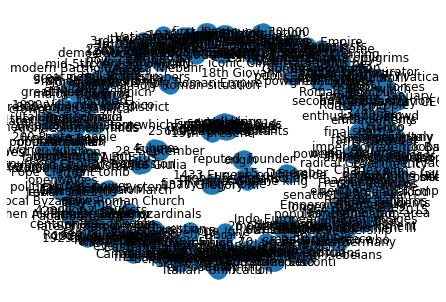

In [85]:
nx.draw(G, with_labels=True, cmap=plt.cm.Dark2)
plt.show()

In [161]:
for a, b in G.adjacency():
    for c, d in b.items():
        print(a)
        print(c)
        print(d["relation"])
    break

5th  Rome
regional  Latium
gained regional


In [139]:
## setup
pos = nx.spring_layout(G, k=0.2)
for n,p in pos.items():
    G.nodes[n]['pos'] = p
    
## links
edge_x, edge_y = [], []
arrows = []
for n,edge in enumerate(G.edges()):
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    arrows.append([[x0,y0],[x1,y1]])

edge_trace = go.Scatter(x=edge_x, y=edge_y, mode='lines', showlegend=False)

## nodes
node_x, node_y = [], []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', showlegend=False,
                        marker={"showscale":False, "colorscale":'YlGnBu', "reversescale":True, 
                                "size":10, "line_width":2})

## add details
link_text, node_text, node_color, node_size = [], [], [], []
for adjacencies in G.adjacency():
    node_text.append(adjacencies[0])
    for dic in adjacencies[1].values():
        link_text.append(dic["relation"])

node_trace.text = node_text
edge_trace.text = link_text

## layout
fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(title="History of Rome", showlegend=True, plot_bgcolor='white', 
                  hovermode='closest', width=800, height=800,
                  xaxis={"visible":False}, yaxis={"visible":False})

fig.show()

In [104]:
## setup
pos = nx.spring_layout(G, k=0.3)
for n,p in pos.items():
    G.nodes[n]['pos'] = p
    
## links
edge_x, edge_y = [], []
edge_color, edge_size = [], []
arrows = []
for n,edge in enumerate(G.edges()):
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    #edge_color.append(colors[data[cat].iloc[n]])
    #edge_size.append(data[value].iloc[n])
    arrows.append([[x0,y0],[x1,y1]])

edge_trace = go.Scatter(x=edge_x, y=edge_y, mode='lines', showlegend=False)

## nodes
node_x, node_y = [], []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', showlegend=False,
                        marker={"showscale":False, "colorscale":'YlGnBu', "reversescale":True, 
                                "size":10, "line_width":2})

## add node details
node_text, node_color, node_size = [], [], []
for node, adjacencies in enumerate(G.adjacency()):
    ### node text = company name
    node_text.append(adjacencies[0])  
    ### node color = how many links
    node_color.append(len(adjacencies[1]))
    ### node size = how much cash
    cash = sum([i[value] for i in adjacencies[1].values()])
    cash = 20 if cash > 10 else (30 if cash > 20 else np.clip(a=cash, a_min=5, a_max=10))
    node_size.append(cash)

node_trace.text = node_text
node_trace.marker.color = node_color
node_trace.marker.size = node_size

## layout
fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(title='search: {}'.format(' + '.join(lst)), showlegend=True, plot_bgcolor='white', 
                  hovermode='closest', width=800, height=800,
                  xaxis={"visible":False}, yaxis={"visible":False})

## add directions
fig.update_layout(annotations=[{"ax":i[0][0], "ay":i[0][1], "axref":'x', "ayref":'y',
                                 "x":i[1][0],  "y":i[1][1],  "xref":'x',  "yref":'y',
                                "showarrow":True, "arrowhead":4, 
                                "arrowcolor":edge_color[n]} 
                              for n,i in enumerate(arrows)])

## add legend
for k,v in colors.items():
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers", name=k, 
                             marker={"size":7, "color":v, "symbol":'square'}))

fig.show()

IndexError: list index out of range

### 3 - Timeline

In [100]:
 dateparser.parse("the 5th century").strftime('%Y')

AttributeError: 'NoneType' object has no attribute 'strftime'